<a href="https://colab.research.google.com/github/zopeabhijit/amazon-sales/blob/main/amazon-sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload amazon.csv file in /home folder, before executing

In [ ]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt

prod_df = pd.read_csv('/home/amazon.csv')

# Remove duplicate rows
print("Total rows which are duplicates: ", len(prod_df.duplicated()))
prod_df.drop_duplicates(inplace=True)
print("Removed duplicate rows")

# Identify how much data is missing
prod_df.replace('', np.nan)
print("\nTotal rows having null/invalid values (only column rating_count has null values): ", len(prod_df[prod_df.isna().any(axis=1)]))
print('\nTotal rows having no reviews: ', len(prod_df[prod_df['review_id'].apply(len) == 0]))

# Summarize the dataset
total_products = prod_df['product_id'].nunique()
print("\nTotal number of unique products: ", total_products)
print("Total number of unique users: ", len(np.unique(np.concatenate(prod_df['user_id'].str.split(',').to_numpy()))))
print("Total number of unique reviews: ", len(np.unique(np.concatenate(prod_df['review_id'].str.split(',').to_numpy()))))

print("\nTop 5 categories by number of products:\n")
print(prod_df.groupby('category')['product_id'].count().sort_values(ascending=False)[0:5].rename('Total_Products'))

################## Clean and preprocess the data ##################
# Convert prices to numeric
prod_df['actual_price'] = prod_df['actual_price'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(float)
prod_df['discounted_price'] = prod_df['discounted_price'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(float)
prod_df['discount_percentage'] = prod_df['discount_percentage'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(float)

# Price range and discount insights
print('\nActual price ranges from {0} to {1}'.format(prod_df['actual_price'].min(), prod_df['actual_price'].max()))
print('Discounted price ranges from {0} to {1}'.format(prod_df['discounted_price'].min(), prod_df['discounted_price'].max()))
print('Discount percentage ranges from {0} to {1}'.format(prod_df['discount_percentage'].min(), prod_df['discount_percentage'].max()))

# Compute rating_count median
rating_count_median = prod_df[prod_df['rating_count'].notna()]['rating_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int).median()
print("\nMedian for column rating_count is: ", rating_count_median)

# Convert rating_count to integer format and replace NaN values with rating_count median
prod_df['rating_count'] = prod_df[prod_df['rating_count'].notna()]['rating_count'].apply(lambda x: re.sub(r'[^0-9]', '', x)).astype(int)
prod_df.fillna({'rating_count': rating_count_median}, inplace=True)

# Parse categories into hierarchy levels
columns = ['Level0', 'Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6']
prod_df[columns] = prod_df['category'].str.split('|', expand=True)
prod_df.set_index(columns)

# Normalize rating scores (weighted average)
# (First fill missing rating values with the mean of rating)
rating_mean = prod_df[prod_df['rating'] != '|']['rating'].astype(float).mean() # Only 1 row has non numerica data as rating
prod_df.loc[prod_df['rating'] == '|','rating'] = rating_mean
prod_df['rating'] = prod_df['rating'].astype(float)
prod_df['rating_normal'] = prod_df.apply(lambda x: (x['rating'] * x['rating_count'] + rating_mean * rating_count_median) / (x['rating_count'] + rating_count_median), axis=1)
print('Normalized rating scores range from {0} to {1}'.format(prod_df['rating_normal'].min(), prod_df['rating_normal'].max()))

# Count outliers
q1 = np.percentile(prod_df['rating_normal'], 25)
q3 = np.percentile(prod_df['rating_normal'], 75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = prod_df[(prod_df['rating_normal'] < lower_bound) | (prod_df['rating_normal'] > upper_bound)]['rating_normal']
print('\nNo. of outliers in rating_normal column on lower side: ', len(prod_df[(prod_df['rating_normal'] < lower_bound)]['rating_normal']))
print('No. of outliers in rating_normal column on higher side: ', len(prod_df[(prod_df['rating_normal'] > upper_bound)]['rating_normal']))

# Count no of reviews for each product
prod_df['review_count'] = prod_df['review_id'].apply(lambda x : len(x.split(',')))




Total rows which are duplicates:  1465
Removed duplicate rows

Total rows having null/invalid values (only column rating_count has null values):  2

Total rows having no reviews:  0

Total number of unique products:  1351
Total number of unique users:  9050
Total number of unique reviews:  9269

Top 5 categories by number of products:

category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables    233
Electronics|WearableTechnology|SmartWatches                                           76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                  68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                         63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                          52
Name: Total_Products, dtype: int64

Actual price ranges from 39.0 to 433296.0
Discounted price ranges from 39.0 to 365766.0
Discount percentage ranges from 0.0 to 94.0

Median for column rating_count is:  517

In [ ]:
import numpy as np
def onehot(arr):

    """
        Input arr is numpy array here
        Output an array of dimension (arr.size, max(array)+1)
    """

    vec_size = max(arr) + 1
    matrix = []
    for elem in arr:
        row = [0]*vec_size
        row[elem] = 1
        matrix.append(row)

    return np.array(matrix)

onehot([1,2,3,4])

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [ ]:
# value_for_money_score

# Create TF-IDF score for review column
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate matrix of TF-IDF values (only first 50 products for now)
prod_review_df = prod_df[0:50][['product_id', 'review_title', 'review_content']]
tfidf = TfidfVectorizer()
result = tfidf.fit_transform((prod_review_df['review_title']+prod_review_df['review_content']).to_numpy())

# Function that returns tf-idf score
def tf_idf_score(row):

  # words that highlight value for money
  words = ['worth', 'worthy', 'budget', 'affordable', 'value', 'effective']

  words_index = [tfidf.vocabulary_.get(word) for word in words]
  return np.sum(result.toarray()[int(row.name)][words_index])

# Generate score
prod_review_df['value_score'] = prod_review_df.apply(tf_idf_score, axis=1)

# Predict
prod_review_df.sort_values('value_score', ascending=False).head(5)

,product_id,review_title,review_content,value_score
36,B07XLCFSSN,"Good,Worth to buy,Great value for price,Good p...",Good budget mfi certified lightly cable for th...,0.330960
26,B08B42LWKN,"Worthy and most affordable - Great TV,Good pro...",This OnePlus TV is great if you want a afforda...,0.274255
37,B09RZS1NQT,"Worth it!,Good one,Robust and effective.,Good,...",It does the job really well. No complaints reg...,0.265786
39,B09C6HWG18,"Product is as expected,Cable has problem with ...",Same type is available in half prize other mak...,0.241572
28,B09W5XR9RT,"Very good product.,Using as a spare cable in c...","Fast charging.,Cable seems to be of good quali...",0.192751


In [ ]:
import numpy as np
# import logistic regression model
from sklearn.linear_model import LogisticRegression

def predict_class(X_train, y_train, X_test):
    '''X_train, y_train, X_test are all in the form of lists
       Output -> A numpy array of class labels of the same length as of X_test is expected to be returned'''

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)

    #initialize the logistic regression model
    clf = LogisticRegression()

    #fit the training data on the model
    clf.fit(X_train, y_train)

    #predict the labels of the observations in X_test
    predictions = clf.predict(X_test)
    return predictions

(array([0.04, 0.73, 0.38, 5.98, 3.1 , 0.75, 0.  , 0.17, 1.91, 0.19]),
 array([  0.47, -20.28,  10.52,  -1.  ,  -8.59, -10.07,   0.  ,   4.36,
         -3.41,   6.18]))

In [ ]:
import numpy as np
def main():
    # YOUR CODE GOES HERE
    # Please take input and print output to standard input/output (stdin/stdout)
    # E.g. 'input()/raw_input()' for input & 'print' for output
    str1 = input()
    t_true = [int(elem) for elem in str1.split(' ')]
    str1 = input()
    t_pred = [int(elem) for elem in str1.split(' ')]

    print(t_true)
    matrix_size = max(t_true)+1
    total = len(t_true)
    confusion_matrix = np.zeros((matrix_size,matrix_size))
    for i in range(0,total):
        confusion_matrix[t_true[i]][t_pred[i]] += 1

    print(confusion_matrix)

    precision = np.zeros(matrix_size)
    recall = np.zeros(matrix_size)
    f1 = np.zeros(matrix_size)
    for i in range(0, matrix_size):
        precision[i] = confusion_matrix[i][i] / np.sum(confusion_matrix[:,i])
        recall[i] = confusion_matrix[i][i] / np.sum(confusion_matrix[i])
    precision = np.nan_to_num(precision)
    print(precision)
    recall = np.nan_to_num(recall)
    print(recall)
    f1 = 2*(precision*recall)/(precision+recall)
    print(f1)

    return np.nan_to_num(f1)

if __name__ == '__main__':
    main()

2 4 3 1 3 0 0 3 0 5 5 4 5 4 2 5 2 0 5 3 1 3
4 4 5 5 0 3 0 3 2 5 1 2 2 0 2 4 4 3 3 3 4 4
[2, 4, 3, 1, 3, 0, 0, 3, 0, 5, 5, 4, 5, 4, 2, 5, 2, 0, 5, 3, 1, 3]
[[1. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 2. 0.]
 [1. 0. 0. 2. 1. 1.]
 [1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1.]]
[0.33333333 0.         0.25       0.4        0.16666667 0.33333333]
[0.25       0.         0.33333333 0.4        0.33333333 0.2       ]
[0.28571429        nan 0.28571429 0.4        0.22222222 0.25      ]


/tmp/ipython-input-14-3234062889.py:30: RuntimeWarning: invalid value encountered in divide
  f1 = 2*(precision*recall)/(precision+recall)


Note:

(1) Above are 5 products displayed by best value for money score (any non zero value is a value for money product, since frequency for a favourable word will be just generally 1 or 2, not more than that)

(2) Score was computed only for first 50 products, as processing time was too much for all products.

(3) Can think of using bigrams/trigrams in future (as of now used unigrams only)

Top 10 categories by no. of reviews:
category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                        1847
Electronics|WearableTechnology|SmartWatches                                                               596
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                      505
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                             490
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                              400
Electronics|HomeTheater,TV&Video|Accessories|RemoteControls                                               380
Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances|MixerGrinders                                  216
Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cleaning&Ironing|Irons,Steamers&Accessories|Irons|DryIrons     192
Computers&Accessories|Accessories&Peripherals|Keyboards,Mice&InputDevices|

Text(0, 0.5, 'No. Of Reviews')

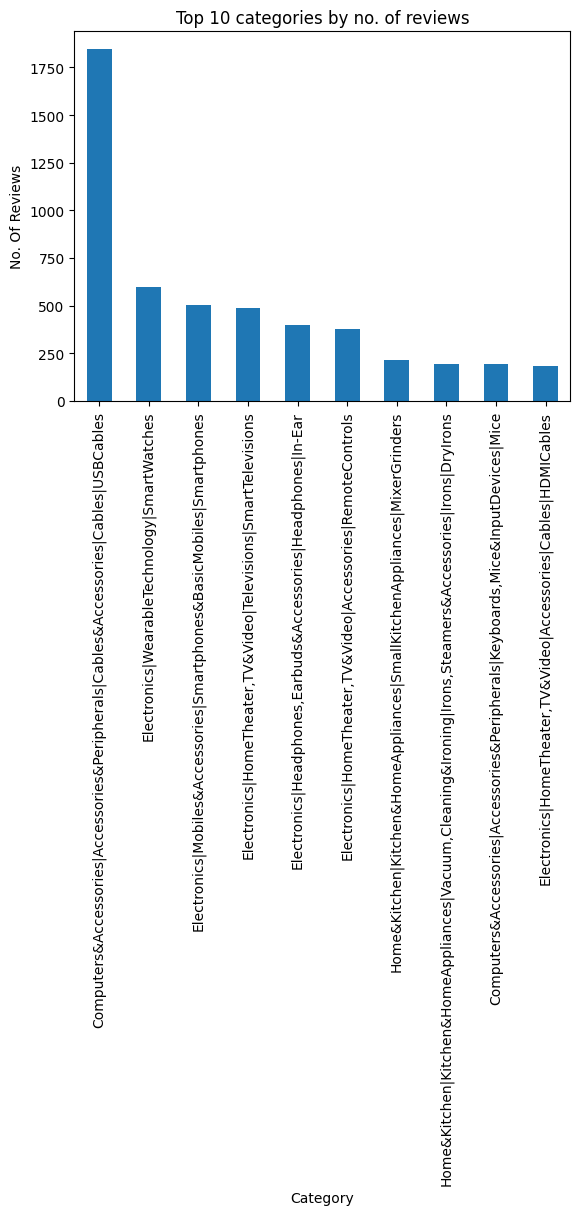

In [ ]:
# Section B: Exploratory Data Analysis

# Top 10 categories by number of reviews.
category_total_reviews_df = prod_df.groupby('category')['review_count'].sum().sort_values(ascending=False)[0:10].rename('Total_Reviews')
print('Top 10 categories by no. of reviews:')
print(category_total_reviews_df)
category_total_reviews_df.plot(kind='bar')

plt.title('Top 10 categories by no. of reviews')
plt.xlabel('Category')
plt.ylabel('No. Of Reviews')


Text(0, 0.5, 'Mean Rating')

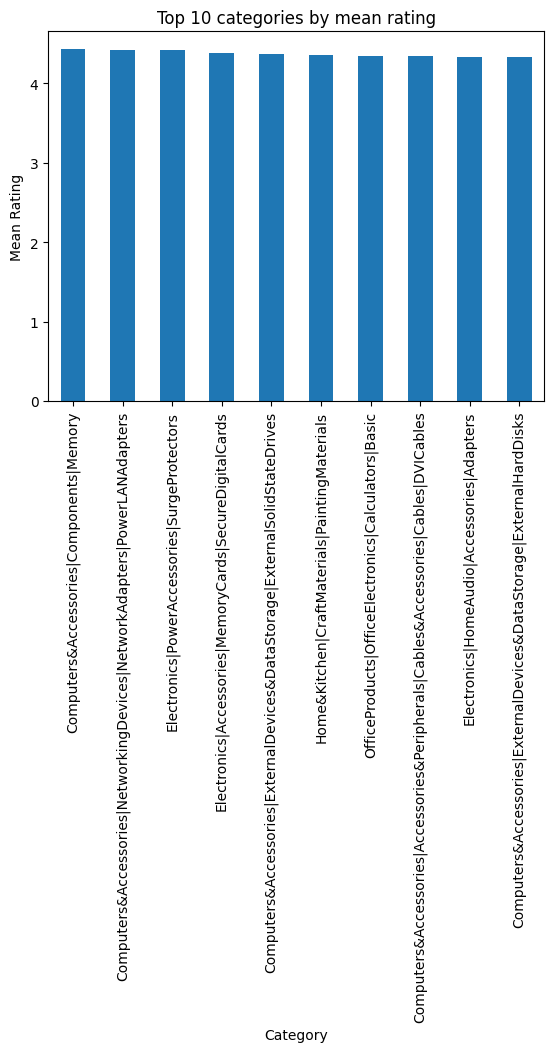

In [ ]:
# Average rating per category

average_rating_df = prod_df.groupby('category')['rating_normal'].mean().sort_values(ascending=False)[0:10].rename('Average_Rating')
average_rating_df.plot(kind='bar')

plt.title('Top 10 categories by mean rating')
plt.xlabel('Category')
plt.ylabel('Mean Rating')

In [ ]:
# Discounts vs actual price correlation
pearsons_correlation = prod_df['discount_percentage'].corr(prod_df['actual_price'], method='pearson')
print('\nCorrelation between Discounts and actual price:', pearsons_correlation)


Correlation between Discounts and actual price: -0.10576128992773992


Very weak negative or no correlation between Discounts and actual price. At most it can be said that some cheap products get a bit higher discount and vice versa, but in very few cases, else no trend as such.

In [ ]:
#  Which products have high ratings but low review counts?

# Check min and max values for review_count and normalized rating value
print('Review count values (overall) in the dataset:', prod_df['review_count'].min(), ' to ', prod_df['review_count'].max())
print('Mean of normalized ratings:', prod_df['rating_normal'].mean())
print('Minimum of normalized ratings:', prod_df['rating_normal'].min())
print('Maximum of normalized ratings:', prod_df['rating_normal'].max())

# Display the products
prod_df[(prod_df['rating_normal'] > 4) & (prod_df['review_count'] <= 3)][['product_id', 'rating_normal', 'review_count']].sort_values('rating_normal', ascending=False).head(10)

Review count values (overall) in the dataset: 1  to  8
Mean of normalized ratings: 4.11567966452141
Minimum of normalized ratings: 3.5346477393716844
Maximum of normalized ratings: 4.738235599987622


,product_id,rating_normal,review_count
1145,B0BR4F878Q,4.738236,3
324,B0BQRJ3C47,4.548292,1
394,B07WDKLDRX,4.338353,2
137,B08TGG316Z,4.305169,3
1306,B0B19VJXQZ,4.250015,2
568,B08VB57558,4.183755,2
977,B083T5G5PM,4.099829,2
366,B09TWH8YHM,4.099357,2
411,B0B14MR9L1,4.099357,2
361,B09TWHTBKQ,4.099357,2


Considering that mean of normalized rating itself is 4.11 and also consider min and max values, only the topmost 2 products in above list can be considered as 'highly rated' and also 'less reviewed'

In [ ]:
# Are highly rated products also heavily reviewed?

prod_df[(prod_df['rating_normal'] > 4) & (prod_df['review_count'] >= 6)][['product_id', 'rating_normal', 'review_count']].sort_values('rating_normal', ascending=False).head(10)

,product_id,rating_normal,review_count
820,B01J1CFO5I,4.532479,8
447,B095RTJH1M,4.517967,8
864,B09X7DY7Q4,4.490062,8
40,B00NH11KIK,4.481489,8
852,B00NH11KIK,4.481489,8
810,B07G3YNLJB,4.478703,8
212,B00NH13Q8W,4.473935,8
30,B00NH11PEY,4.473934,8
802,B00NH11PEY,4.473934,8
734,B004IO5BMQ,4.464935,8


Yes, top 2-3 products can be considered as 'highly rated' and also 'highly reviewed'

In [ ]:
# Vectorize product text (about_product + product_name) using: TF-IDF or embeddings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Generate matrix of TF-IDF values
tfidf = TfidfVectorizer(max_features=20)
result = tfidf.fit_transform((prod_df['product_name']+prod_df['about_product']).to_numpy())

print('TF-IDF Matrix: \n', result.toarray())

# Generate Cosine similarity matrix
cosine_sim_matrix = cosine_similarity(result.toarray())

print('\nCosine similarity Matrix: \n', cosine_sim_matrix)

# Let us find a product with min reviews
print('\nProducts with minimum reviews:')
prod_df[prod_df['review_count'] == 1][['product_id', 'product_name', 'review_count']]


TF-IDF Matrix: 
 [[0.42263499 0.14815025 0.13609085 ... 0.22345121 0.11974974 0.21409288]
 [0.06662211 0.56048832 0.         ... 0.14089501 0.         0.10124566]
 [0.68305801 0.22102044 0.20302941 ... 0.27779952 0.17865066 0.        ]
 ...
 [0.57059338 0.         0.         ... 0.20111883 0.         0.        ]
 [0.26092071 0.         0.         ... 0.5518052  0.         0.        ]
 [0.15653831 0.         0.         ... 0.         0.         0.        ]]

Cosine similarity Matrix: 
 [[1.         0.64462891 0.73104757 ... 0.3017315  0.48408071 0.26447439]
 [0.64462891 1.         0.35823313 ... 0.08114186 0.13981677 0.1955711 ]
 [0.73104757 0.35823313 1.         ... 0.52344061 0.68320523 0.4558271 ]
 ...
 [0.3017315  0.08114186 0.52344061 ... 1.         0.58838042 0.35592298]
 [0.48408071 0.13981677 0.68320523 ... 0.58838042 1.         0.55389529]
 [0.26447439 0.1955711  0.4558271  ... 0.35592298 0.55389529 1.        ]]

Products with minimum reviews:


,product_id,product_name,review_count
155,B09XJ1LM7R,7SEVEN® Compatible for Tata Sky Remote Origina...,1
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,1
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",1
1459,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,1


As there are no products with Zero reviews, let us take one of the above products viz 'B09XJ1LM7R' and find similar products to it.

We can see that after including category, price and discount in the vector, an entirely different set of similar products were recommended in case of both product id's we have taken into consideration.

Also similarity score is almost nearing 1 in the 2nd case.

In [ ]:
# Get top 5 similar products for product_id B09XJ1LM7R
def get_top_similar_products(product_id, cosine_sim_matrix):
  product_index = prod_df[prod_df['product_id'] == product_id].index[0]
  top_similar_product_indices = sorted(list(enumerate(cosine_sim_matrix[product_index])), key=lambda x:x[1], reverse=True)[1:6]
  top_similar_products = pd.DataFrame([prod_df.iloc[i[0]][['product_id','product_name','about_product']] for i in top_similar_product_indices])
  top_similar_products['similarity_score'] = [i[1] for i in top_similar_product_indices]
  return top_similar_products

print('Products similar to product_id B09XJ1LM7R:')
get_top_similar_products('B09XJ1LM7R', cosine_sim_matrix)


Products similar to product_id B09XJ1LM7R:


,product_id,product_name,about_product,similarity_score
128,B09MM6P76N,7SEVEN® Compatible Lg Smart Tv Remote Suitable...,Best Compatible Remote Control for LG televisi...,0.828974
1279,B08L12N5H1,Eureka Forbes car Vac 100 Watts Powerful Sucti...,No Installation is provided for this product|1...,0.815543
1067,B009P2LK08,Bajaj Minor 1000 Watts Radiant Room Heater (St...,Radiant Warmth: Ideal for use in in small room...,0.806932
179,B08XMSKKMM,7SEVEN® Bluetooth Voice Command Remote for Xia...,Compatible with MI Smart TV 4A 32 inch Led TV ...,0.805236
60,B07B275VN9,"Airtel DigitalTV DTH Television, Setup Box Rem...",This is Generic Airtel Tv Remote|Universal con...,0.799993


In [ ]:
# A product with high user dropout (bad ratings)

print('Worst rated products:')
prod_df.sort_values('rating_normal')[['product_id', 'product_name', 'rating_normal']].head(5)

Worst rated products:


,product_id,product_name,rating_normal
415,B085W8CFLH,PTron Tangent Lite Bluetooth 5.0 Earphones wit...,3.534648
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,3.548292
45,B07XJYYH7L,Wecool Nylon Braided Multifunction Fast Chargi...,3.575567
857,B07XJYYH7L,Wecool Nylon Braided Multifunction Fast Chargi...,3.575567
1036,B07GXPDLYQ,PRO365 Indo Mocktails/Coffee Foamer/Cappuccino...,3.603213


Let us find products similar to the first one above viz. 'B085W8CFLH'

In [ ]:
print('Products similar to product_id B085W8CFLH:')
get_top_similar_products('B085W8CFLH', cosine_sim_matrix)

Products similar to product_id B085W8CFLH:


,product_id,product_name,about_product,similarity_score
349,B08D77XZX5,PTron Tangentbeat in-Ear Bluetooth 5.0 Wireles...,Ergonomic Magnetic Earbuds; Secure-fit; Sweat ...,0.955878
237,B0B5F3YZY4,Wayona 3in1 Nylon Braided 66W USB Fast Chargin...,[3 in 1 Fast Charging Cable] : 3 in 1 Multi Ch...,0.872058
213,B0B8SSZ76F,Amazon Basics USB C to Lightning TPE MFi Certi...,TPE MFi-certified charging cable to fast charg...,0.859034
730,B07B88KQZ8,"JBL Go 2, Wireless Portable Bluetooth Speaker ...",5 Hours of Playtime under optimum audio settin...,0.834620
186,B0B8SSC5D9,AmazonBasics USB C to Lightning Aluminum with ...,Nylon-braided charging cable with a USB-C powe...,0.824780


In [ ]:
# Add category, price, and discount to enhance content vectors

# First normalize them between 0 and 1

from sklearn.preprocessing import MinMaxScaler

# Generate matrix of normalized values for price and discount
price_discount_matrix = MinMaxScaler().fit_transform(prod_df[['actual_price','discount_percentage']])

# Generate matrix of TF-IDF values for category (as it is in string format)
tfidf = TfidfVectorizer(max_features=3)
category_matrix = tfidf.fit_transform((prod_df['category']).to_numpy()).toarray()

# Merge the 3 matrices horizontally
final_matrix = np.hstack((result.toarray(), category_matrix, price_discount_matrix))

# Generate Cosine similarity matrix
cosine_sim_matrix_new = cosine_similarity(final_matrix)
print('\nCosine similarity Matrix (that includes category, price and discount): \n\n', cosine_sim_matrix)

pd.set_option('display.expand_frame_repr', False)
# Generate similar products
print('\nProducts similar to product_id B09XJ1LM7R:')
print(get_top_similar_products('B09XJ1LM7R', cosine_sim_matrix_new))

print('\nProducts similar to product_id B085W8CFLH:')
print(get_top_similar_products('B085W8CFLH', cosine_sim_matrix_new))


Cosine similarity Matrix (that includes category, price and discount): 

 [[1.         0.64462891 0.73104757 ... 0.3017315  0.48408071 0.26447439]
 [0.64462891 1.         0.35823313 ... 0.08114186 0.13981677 0.1955711 ]
 [0.73104757 0.35823313 1.         ... 0.52344061 0.68320523 0.4558271 ]
 ...
 [0.3017315  0.08114186 0.52344061 ... 1.         0.58838042 0.35592298]
 [0.48408071 0.13981677 0.68320523 ... 0.58838042 1.         0.55389529]
 [0.26447439 0.1955711  0.4558271  ... 0.35592298 0.55389529 1.        ]]

Products similar to product_id B09XJ1LM7R:
     product_id                                       product_name                                      about_product  similarity_score
128  B09MM6P76N  7SEVEN® Compatible Lg Smart Tv Remote Suitable...  Best Compatible Remote Control for LG televisi...          0.922237
179  B08XMSKKMM  7SEVEN® Bluetooth Voice Command Remote for Xia...  Compatible with MI Smart TV 4A 32 inch Led TV ...          0.914860
60   B07B275VN9  Airtel Digit

In [ ]:
# Section D: Collaborative Filtering (User–Item)

# User-product matrix using user_id, product_id and REVIEWED (Since data about Rating given by each user is not available)
prod_user_df = prod_df[['product_id', 'user_id']]
user_df = prod_user_df['user_id'].str.split(',', expand=True)
prod_user_df = pd.concat([prod_user_df, user_df], axis=1)
prod_user_df = pd.melt(prod_user_df, id_vars=['product_id'], value_vars=user_df.columns)
prod_user_df.drop(columns=['variable'], inplace=True)
prod_user_df.rename(columns={'value':'user_id'}, inplace=True)
prod_user_df.sort_values('user_id', inplace=True)
prod_user_df['reviewed'] = True
prod_user_df.reset_index(drop=True, inplace=True)

print('product_id versus user_id matrix: \n', prod_user_df[['user_id','product_id','reviewed']])


product_id versus user_id matrix: 
                             user_id  product_id  reviewed
0      AE22E2AXODSPNK3EBIHNGYS5LOSA  B0B31FR4Y2      True
1      AE22MK2NXQD3ZARLIOL3SLD4GU6A  B0B8XNPQPN      True
2      AE22Y3KIS7SE6LI3HE2VS6WWPU4Q  B07ZR4S1G4      True
3      AE23RS3W7GZO7LHYKJU6KSKVM4MQ  B00HVXS7WC      True
4      AE23WGYTUMB5R6JJMBU4V43JIW7Q  B09163Q5CD      True
...                             ...         ...       ...
11715                          None  B09ZVJXN5L      True
11716                          None  B0BL3R4RGS      True
11717                          None  B0BP89YBC1      True
11718                          None  B0B9JZW1SQ      True
11719                          None  B0B3JSWG81      True

[11720 rows x 3 columns]


In [ ]:
!pip install -q lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import coo_matrix

# Initialize Dataset
dataset = Dataset()
dataset.fit(
    items=prod_user_df['product_id'].unique(),
    users=prod_user_df['user_id'].unique()
)

# Build interactions
interactions, _ = dataset.build_interactions(
    [(row['user_id'], row['product_id'], float(row['reviewed']))
     for _, row in prod_user_df.iterrows()]
)

# Train the LightFM model using WARP loss
model = LightFM(no_components=32, loss='warp', random_state=42)

# Train using only interactions (weights not available)
model.fit(interactions, epochs=20, num_threads=2)
print("Model trained!")

Model trained!


Let us predict products for user AE22E2AXODSPNK3EBIHNGYS5LOSA

In [ ]:
    user_id = 'AE22E2AXODSPNK3EBIHNGYS5LOSA'

    user_id_map, _, item_id_map, _ = dataset.mapping()
    internal_user_id = user_id_map[user_id]
    num_items = len(item_id_map)

    # Predict scores for all items for the user
    scores = model.predict(user_ids=internal_user_id, item_ids=np.arange(num_items))

    # Get top N item indices (internal IDs)
    top_indices = np.argsort(-scores)[:5]  # negative for descending sort

    # Reverse mapping: internal to external product_id
    inv_item_id_map = {v: k for k, v in item_id_map.items()}
    recommended_products_ids = [inv_item_id_map[i] for i in top_indices]

    print('Recommended products for user_id', user_id, ':')
    print(recommended_products_ids)


Recommended products for user_id AE22E2AXODSPNK3EBIHNGYS5LOSA :
['B0B31FR4Y2', 'B08PSQRW2T', 'B094DQWV9B', 'B08HQL67D6', 'B0762HXMTF']


In [ ]:
def recommended_products_ids(group_df):
    # Access the user_id from the index of the group DataFrame
    user_id = group_df.name
    seen_products_count = len(group_df['product_id'].unique())

    # Handle cases where user_id might be None
    if user_id is None:
        return []

    user_id_map, _, item_id_map, _ = dataset.mapping()

    # Check if the user_id exists in the mapping
    if user_id not in user_id_map:
        return []

    internal_user_id = user_id_map[user_id]
    num_items = len(item_id_map)

    # Predict scores for all items for the user
    scores = model.predict(user_ids=internal_user_id, item_ids=np.arange(num_items))

    # Get top N item indices (internal IDs)
    # Seen products (reviwed) will have top scores, so to be skipped from the top
    top_indices = np.argsort(-scores)[seen_products_count:seen_products_count+5]

    # Reverse mapping: internal to external product_id
    inv_item_id_map = {v: k for k, v in item_id_map.items()}
    recommended_products_ids = [inv_item_id_map[i] for i in top_indices]

    # Filter out products the user has already reviewed
    #recommended_products_ids = [product_id for product_id in recommended_products_ids if product_id not in seen_products]

    return recommended_products_ids[:5] # Return top 5 recommendations


recommended_products_df = prod_user_df.groupby('user_id').apply(recommended_products_ids)
recommended_products_df

/tmp/ipython-input-33-1797148856.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommended_products_df = prod_user_df.groupby('user_id').apply(recommended_products_ids)


,0
user_id,
AE22E2AXODSPNK3EBIHNGYS5LOSA,"[B08PSQRW2T, B094DQWV9B, B08HQL67D6, B0762HXMT..."
AE22MK2NXQD3ZARLIOL3SLD4GU6A,"[B095K14P86, B081B1JL35, B09F6KL23R, B08FD2VSD..."
AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,"[B07VSG5SXZ, B09QS8V5N8, B09QS9X16F, B0BP7XLX4..."
AE23RS3W7GZO7LHYKJU6KSKVM4MQ,"[B08RDWBYCQ, B097MKZHNV, B09P858DK8, B08QW937W..."
AE23WGYTUMB5R6JJMBU4V43JIW7Q,"[B075TJHWVC, B07H3N8RJH, B09YL9SN9B, B07YQ5SN4..."
...,...
AHZXNS63DN6MZDH3WSKYRLWSG3DA,"[B09NL4DCXK, B07GXPDLYQ, B088ZFJY82, B073BRXPZ..."
AHZYN7O73FJWRPUQGZM5BEAZ3A4A,"[B0162K34H2, B009UORDX4, B081RLM75M, B07ZJND9B..."
AHZZFBL24XXVLW6H44MOB6LBHH5A,"[B08TR61BVK, B07KY3FNQP, B094JNXNPV, B09C6FML9..."


Section E: Hybrid Recommender (Content + Collaborative) :

Design a hybrid strategy:
Score fusion: 0.6 * CF_score + 0.4 * Content_score
Compare recommendation quality of hybrid vs individual methods.

[My point of view]: CF_Score gives user-item suitability and content score gives item-item similarity. How can both be summed up to get one score.

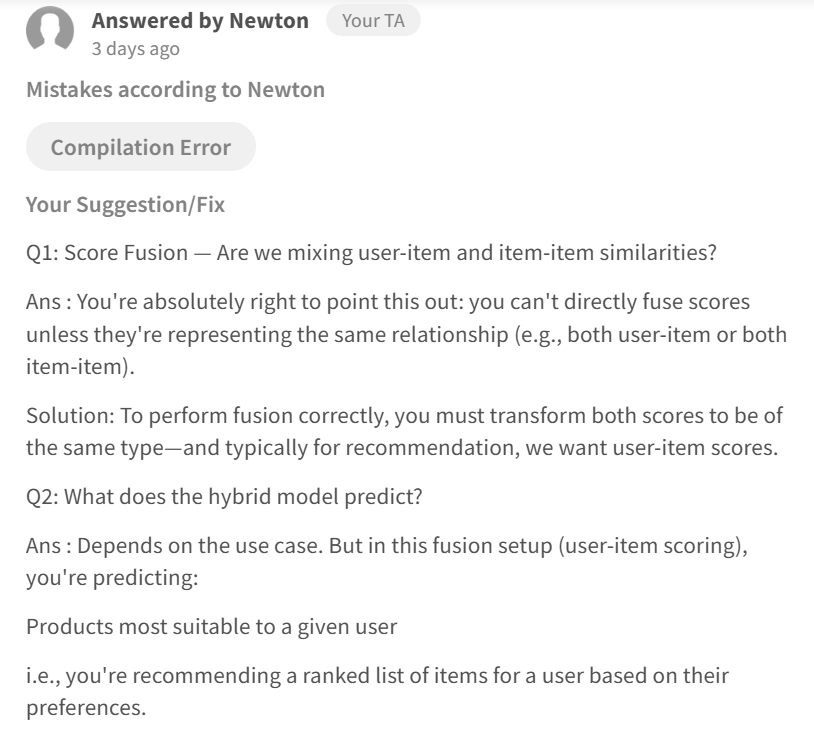

We obviously cannot transform content based score to user-item score (as suggested by TA).


Another hybrid approach could be to first find items suitable for a user based on collaborative filtering and then find items similar to each of the above found items using content based filtering. Again here, the suggested hybrid score formula is not needed.

Cold start user:
  Here most of products are not rated by the user. In this case, we can find similar users based on not item ratings, but on other properties like age, location, profession, hobbies, etc. But this dataset has only product data and no data about user except name.

Cold start product:
  Here most users have not rated the product. In this case, we can find similar items using content based filtering and recommend it to those users who have rated those similar products well.

Suggest how to improve hybrid performance further using real-world constraints like:

Popularity: An item that is popular can be recommended to similar and non-similar users, both, to increase change of a click.

Recent purchases: Recommend items similar to recent purchases of that users and also items recently purchased by similar users, both, to increase change of a purchase.

Product availability: While recommending a list of filtered products to users, reduce the score of those products whose availability is less, something like:

adjusted_score = score*(no_of_available_products/mean)


Section F: Bonus: Business Strategy & Deployment
Which model works best for new users ?

  Same as mentioned above for a Cold start user.

Which model works best for returning users ?

  Recommend newly introduced items which are well rated by similar users (User based collaborative filtering)

How can we recommend products with no ratings?

  Find similar items using content based filtering and recommend it to those users who have rated those similar products well.

How would you deploy this system in production? Mention tools/technologies.

  Develop a REST based service (end point) that takes product_id and/or user_id as input and returns the recommended products. Docker container on AWS or other cloud's VM can be fine.

What KPIs should Amazon track to measure success?

  - Percentage of recommended products getting clicked by respective users.
  - Percentage of recommended products purchased
  - Weighted average of above